In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from reachability.envs.workspace import Workspace2D
from reachability.envs.rotary_nlink import RotaryNLinkEnv
import time

## Testing environment setup

(1, 6)


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=36.0° | EE Delta=0.0000'}, xlabel='X (World)', ylabel='Y (World)'>

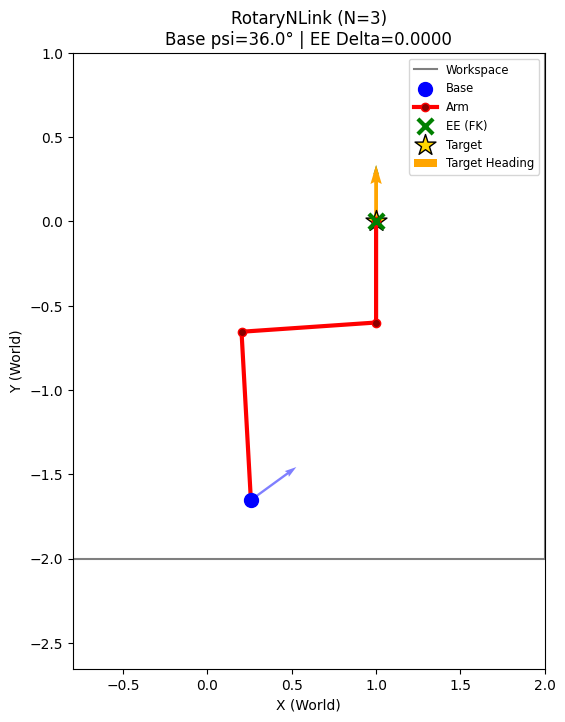

In [36]:
workspace = Workspace2D(-2, 2, -2, 2)
# link_lengths = np.array([1.0, 0.8, 0.6, 0.8, 1.0])
# joint_limits = [[[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/3, np.pi/2]], [[-np.pi/3, np.pi/2]]]
link_lengths = np.array([1.0, 0.8, 0.6])
joint_limits = [[[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]]]
env = RotaryNLinkEnv(workspace, link_lengths=link_lengths, joint_limits=joint_limits, n_links=3) #joint_limits=[[-np.pi, np.pi], [-np.pi, np.pi]],

rng = np.random.default_rng(0)
h_world = np.array([[1, 0, np.pi/2]], dtype=np.float32)
q_sample_world = env.sample_q(h_world, rng)

print(q_sample_world.shape)
env.plot(q_sample_world.flatten(), h_world.flatten())

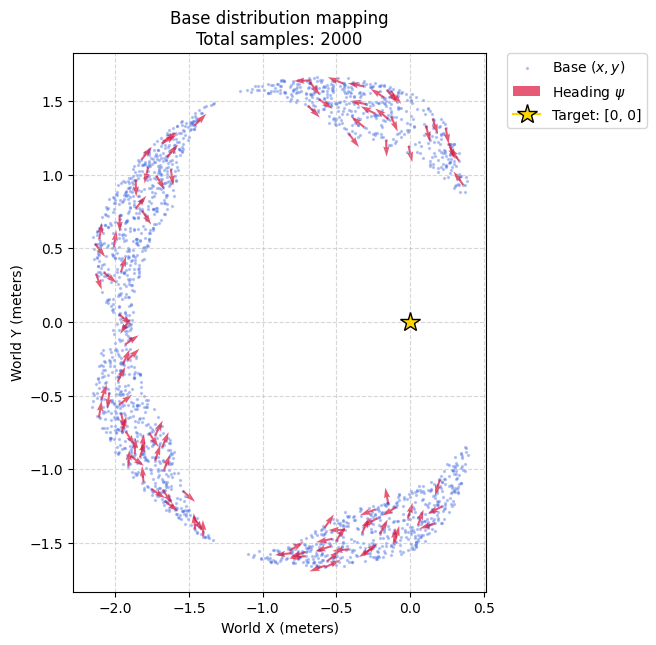

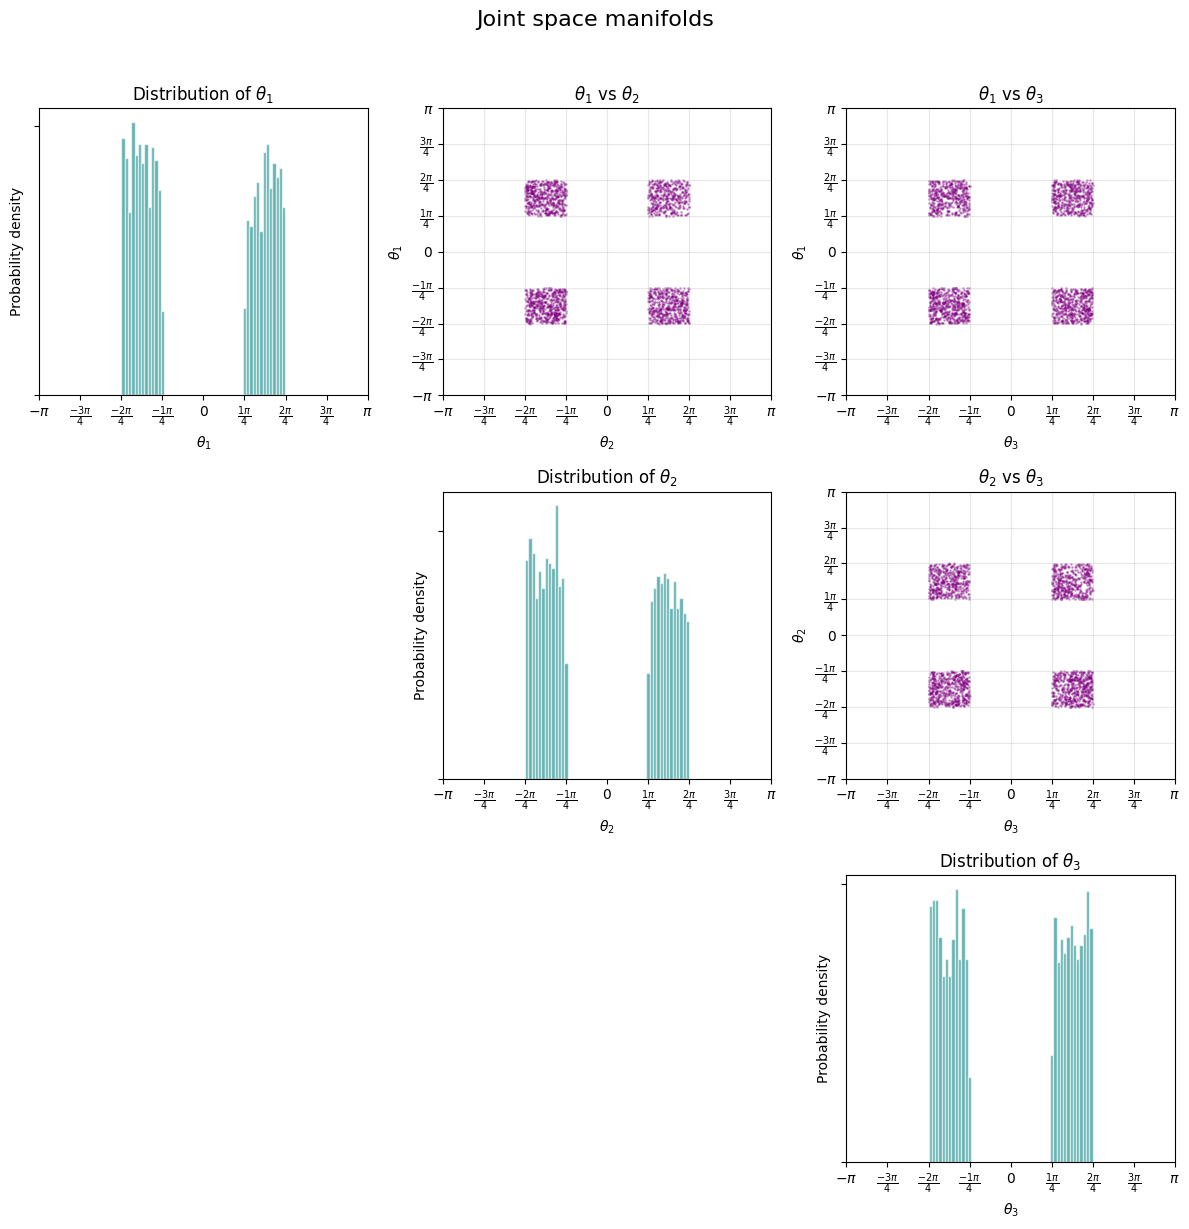

In [51]:
# Data to test on
n_samples = 2000
h_world_example = np.zeros((n_samples, 3), dtype=np.float32)

# 1. Generate 2000 samples for a fixed target at the origin
Q_samples = env.sample_q(h_world_example, rng)

# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, 0]
by = Q_samples[:, 1]
psi = Q_samples[:, 2]
thetas = Q_samples[:, 3:]

from reachability.utils.plotting import plot_data_distribution

plot_data_distribution([0, 0], bx, by, psi, thetas)